Модификация LeNet5 для соревнования CIFAR10

In [1]:
!nvidia-smi

Tue Jul 30 23:05:24 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    28W /  70W |   3184MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [0]:
import torchvision.datasets

In [4]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

0it [00:00, ?it/s]

100%|█████████▉| 170008576/170498071 [00:14<00:00, 14584272.51it/s]

Files already downloaded and verified


In [0]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [0]:
X_train /= 255.
X_test /= 255.

In [7]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

tensor(6) tensor(9) tensor(9) tensor(4) tensor(1) tensor(1) tensor(2) tensor(7) tensor(8) tensor(3) 

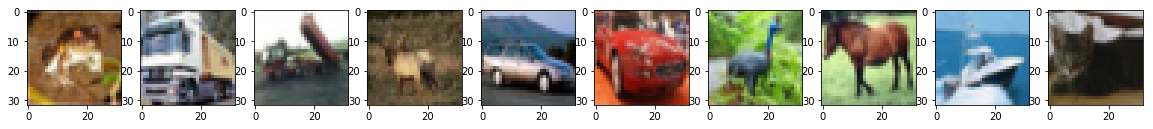

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')

In [9]:
X_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

In [0]:
# Меняет оси
X_train = X_train.permute(0, 3, 1, 2)  # Параметр - порядок осей в новом тензоре относительно старого
X_test = X_test.permute(0, 3, 1, 2)

In [11]:
X_train.shape

torch.Size([50000, 3, 32, 32])

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
class LeNet5(torch.nn.Module):
    def __init__(self,
                 activation='tanh',
                 pooling='avg',
                 conv_size=5, 
                 use_batch_norm=False):
        super(LeNet5, self).__init__()
        
        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm
        
        self.test_accuracy_history = []
        self.test_loss_history = []
        
        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function  = torch.nn.ReLU()
        else:
            raise NotImplementedError
            
        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError
        
        if conv_size == 5:
            self.conv1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv1_1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=3, padding=0)
            self.conv1_2 = torch.nn.Conv2d(
                in_channels=6, out_channels=6, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act1 = activation_function
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = pooling_layer
       
        if conv_size == 5:
            self.conv2 = self.conv2 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv2_1 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=3, padding=0)
            self.conv2_2 = torch.nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act2 = activation_function
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling_layer
        
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = activation_function
    
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = activation_function
        
        self.fc3 = torch.nn.Linear(84, 10)
     
    
    def forward(self, x):
        if self.conv_size == 5:
            x = self.conv1(x)
            
        elif self.conv_size == 3:
            x = self.conv1_2(self.conv1_1(x))
            
        x = self.act1(x)
        
        if self.use_batch_norm:
            x = self.bn1(x)
            
        x = self.pool1(x)
        
        if self.conv_size == 5:
            x = self.conv2(x)
            
        elif self.conv_size == 3:
            x = self.conv2_2(self.conv2_1(x))
            
        x = self.act2(x)
        
        if self.use_batch_norm:
            x = self.bn2(x)
            
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
    def fit(self, X_train, y_train, X_test=None, y_test=None):
        loss = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1.0e-3)

        batch_size = 100

        X_test = X_test.to(device)
        y_test = y_test.to(device)

        for epoch in range(30):
            order = np.random.permutation(X_train.shape[0])
            for start_index in range(0, X_train.shape[0], batch_size):
                optimizer.zero_grad()
                self.train()  # Флаг, чтобы BatchNorm работал корректно

                batch_indexes = order[start_index : start_index + batch_size]

                X_batch = X_train[batch_indexes].to(device)
                y_batch = y_train[batch_indexes].to(device)

                preds = self.forward(X_batch)

                loss_value = loss(preds, y_batch)
                loss_value.backward()

                optimizer.step()


            self.eval()  # Флаг, чтобы BatchNorm работал корректно
            test_preds = self.forward(X_test)
            self.test_loss_history.append(loss(test_preds, y_test).data.cpu())

            accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
            self.test_accuracy_history.append(accuracy)

            print(accuracy)
            
        return self


In [0]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    
    batch_size = 100

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(30):
        order = np.random.permutation(X_train.shape[0])
        for start_index in range(0, X_train.shape[0], batch_size):
            optimizer.zero_grad()
            net.train()  # Флаг, чтобы BatchNorm работал корректно

            batch_indexes = order[start_index : start_index + batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            

        net.eval()  # Флаг, чтобы BatchNorm работал корректно
        test_preds = net.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)

        print(accuracy)
    del net
    return test_accuracy_history, test_loss_history


In [26]:
accuracies = {}
losses = {}

net = LeNet5(activation='tanh', conv_size=5).to(device)
net.fit(X_train, y_train, X_test, y_test)
accuracies['tanh'], losses['tanh'] = net.test_accuracy_history, net.test_loss_history

net = LeNet5(activation='relu', conv_size=5).to(device)
net.fit(X_train, y_train, X_test, y_test)
accuracies['relu'], losses['relu'] = net.test_accuracy_history, net.test_loss_history

net = LeNet5(activation='relu', conv_size=3).to(device)
net.fit(X_train, y_train, X_test, y_test)
accuracies['relu_3'], losses['relu_3'] = net.test_accuracy_history, net.test_loss_history

net = LeNet5(activation='relu', conv_size=3, pooling='max').to(device)
net.fit(X_train, y_train, X_test, y_test)
accuracies['relu_3_max_pool'], losses['relu_3_max_pool'] = net.test_accuracy_history, net.test_loss_history

net = LeNet5(activation='relu', conv_size=3, pooling='max', use_batch_norm=True).to(device)
net.fit(X_train, y_train, X_test, y_test)
accuracies['relu_3_max_pool_bn'], losses['relu_3_max_pool_bn'] = net.test_accuracy_history, net.test_loss_history

tensor(0.4033)
tensor(0.4378)
tensor(0.4717)
tensor(0.4961)
tensor(0.5154)
tensor(0.5242)
tensor(0.5450)
tensor(0.5466)
tensor(0.5470)
tensor(0.5473)
tensor(0.5520)
tensor(0.5609)
tensor(0.5622)
tensor(0.5613)
tensor(0.5611)
tensor(0.5583)
tensor(0.5595)
tensor(0.5690)
tensor(0.5563)
tensor(0.5584)
tensor(0.5644)
tensor(0.5591)
tensor(0.5601)
tensor(0.5563)
tensor(0.5550)
tensor(0.5550)
tensor(0.5549)
tensor(0.5569)
tensor(0.5588)
tensor(0.5491)
tensor(0.4045)
tensor(0.4583)
tensor(0.4946)
tensor(0.5115)
tensor(0.5237)
tensor(0.5383)
tensor(0.5400)
tensor(0.5473)
tensor(0.5536)
tensor(0.5544)
tensor(0.5676)
tensor(0.5676)
tensor(0.5671)
tensor(0.5738)
tensor(0.5749)
tensor(0.5731)
tensor(0.5804)
tensor(0.5903)
tensor(0.5866)
tensor(0.5901)
tensor(0.5920)
tensor(0.5956)
tensor(0.5992)
tensor(0.6012)
tensor(0.6011)
tensor(0.5842)
tensor(0.6003)
tensor(0.5939)
tensor(0.5977)
tensor(0.5957)
tensor(0.3730)
tensor(0.4441)
tensor(0.4793)
tensor(0.5023)
tensor(0.5227)
tensor(0.5412)
tensor(0.5

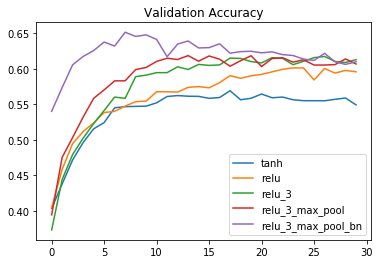

In [27]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

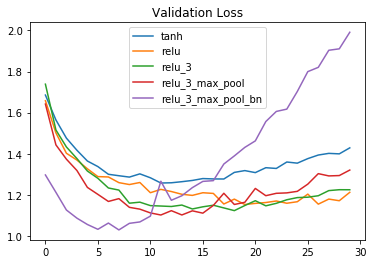

In [28]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');

In [0]:
class CIFARNet(torch.nn.Module):
    def __init__(self):
        super(CIFARNet, self).__init__()
        
        self.test_loss_history = []
        self.test_accuracy_history = []
        
        self.batch_norm0 = torch.nn.BatchNorm2d(num_features=3)
        # Нормировка по яркости и контрасту

        self.conv1 = torch.nn.Conv2d(
            in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.act1  = torch.nn.ReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(num_features=16)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.act2  = torch.nn.ReLU()
        self.batch_norm2 = torch.nn.BatchNorm2d(num_features=32)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = torch.nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.act3  = torch.nn.ReLU()
        self.batch_norm3 = torch.nn.BatchNorm2d(num_features=64)

        self.fc1   = torch.nn.Linear(8 * 8 * 64, 256)
        self.act4  = torch.nn.Tanh()
        self.batch_norm4 = torch.nn.BatchNorm1d(num_features=256)
        
        self.fc2   = torch.nn.Linear(256, 64)
        self.act5  = torch.nn.Tanh()
        self.batch_norm5 = torch.nn.BatchNorm1d(num_features=64)
        
        self.fc3   = torch.nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.batch_norm0(x)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.batch_norm3(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act4(x)
        x = self.batch_norm4(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.batch_norm5(x)
        x = self.fc3(x)
        
        return x
    
    def fit(self, X_train, y_train, X_test=None, y_test=None):
        loss = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1.0e-3)

        batch_size = 100

        X_test = X_test.to(device)
        y_test = y_test.to(device)

        for epoch in range(30):
            order = np.random.permutation(X_train.shape[0])
            for start_index in range(0, X_train.shape[0], batch_size):
                optimizer.zero_grad()
                self.train()  # Флаг, чтобы BatchNorm работал корректно

                batch_indexes = order[start_index : start_index + batch_size]

                X_batch = X_train[batch_indexes].to(device)
                y_batch = y_train[batch_indexes].to(device)

                preds = self.forward(X_batch)

                loss_value = loss(preds, y_batch)
                loss_value.backward()

                optimizer.step()


            self.eval()  # Флаг, чтобы BatchNorm работал корректно
            test_preds = self.forward(X_test)
            self.test_loss_history.append(loss(test_preds, y_test).data.cpu())

            accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
            self.test_accuracy_history.append(accuracy)

            print(accuracy)
            
        return self

In [31]:
net = CIFARNet().to(device)
net.fit(X_train, y_train, X_test, y_test)
accuracies['cifar_net'], losses['cifar_net'] = net.test_accuracy_history, net.test_loss_history

tensor(0.6543)
tensor(0.7122)
tensor(0.7173)
tensor(0.7182)
tensor(0.7230)
tensor(0.7111)
tensor(0.7185)
tensor(0.7188)
tensor(0.7092)
tensor(0.7130)
tensor(0.7162)
tensor(0.7096)
tensor(0.7115)
tensor(0.7163)
tensor(0.7038)
tensor(0.7088)
tensor(0.7118)
tensor(0.7193)
tensor(0.7167)
tensor(0.7142)
tensor(0.7263)
tensor(0.7165)
tensor(0.7141)
tensor(0.7143)
tensor(0.7157)
tensor(0.7174)
tensor(0.7183)
tensor(0.7241)
tensor(0.7194)
tensor(0.7200)


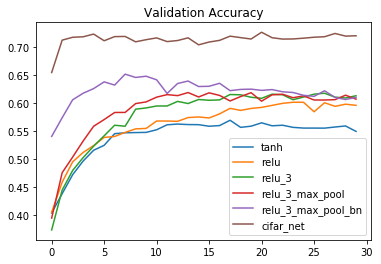

In [32]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

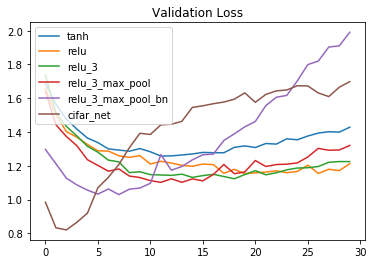

In [33]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');

# ResNet

In [0]:
from torchvision.models import resnet18

In [0]:
accuracies['resnet'], losses['resnet'] = \
    train(resnet18(), X_train, y_train, X_test, y_test)

tensor(0.5317)
tensor(0.6431)
tensor(0.6187)
tensor(0.7126)
tensor(0.6967)
tensor(0.6955)
tensor(0.7392)
tensor(0.7438)
tensor(0.7391)
tensor(0.7403)
tensor(0.7463)
tensor(0.7392)
tensor(0.7370)
tensor(0.7369)
tensor(0.7548)
tensor(0.7469)
tensor(0.7425)
tensor(0.7376)
tensor(0.7580)
tensor(0.7553)
tensor(0.7310)
tensor(0.7417)
tensor(0.7375)
tensor(0.7367)
tensor(0.7486)
tensor(0.7436)
tensor(0.7480)
tensor(0.7385)
tensor(0.7502)
tensor(0.7557)


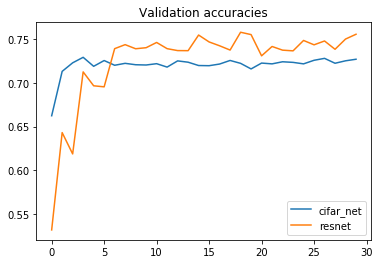

In [0]:
plt.plot(accuracies['cifar_net'], label='cifar_net')
plt.plot(accuracies['resnet'], label='resnet')
plt.legend()
plt.title('Validation Accuracy');

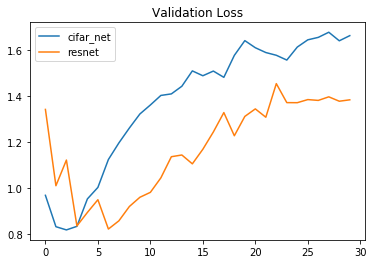

In [0]:
plt.plot(losses['cifar_net'], label='cifar_net')
plt.plot(losses['resnet'], label='resnet')
plt.legend()
plt.title('Validation Loss');